In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.core.debugger import Tracer
from six.moves import cPickle 
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
import os.path as osp
from time import time
import os

sns.set(font='DejaVu Sans')
mpl.rcParams['font.family'] = 'DejaVu Sans'

mpl.rcParams['font.sans-serif'].insert(0, 'DejaVu Sans')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['figure.figsize'] = 12, 4

In [2]:

# Fetch data with the following
#
#   wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#   tar xzf cifar-10-python.tar.gz
# 

DATA_DIR = "/home/tom/datasets/cifar-10-batches-py"

def load_batch(path):
    # https://stackoverflow.com/questions/35995999/why-cifar-10-images-are-not-displayed-properly-using-matplotlib
    f = open(path, 'rb')
    datadict = cPickle.load(f,encoding='latin1')
    f.close()
    X = datadict["data"] 
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float32")
    X = X.reshape(10000, -1)
    Y = np.array(Y)
    return X, Y

im_batches = []
all_labels = []
for i in [1,2,3,4,5]:
    ims, labs = load_batch(osp.join(DATA_DIR, 'data_batch_%s' % i))
    im_batches.append(ims)
    all_labels.append(labs)
    
all_raw_images = np.vstack(im_batches)
all_labels = np.hstack(all_labels)


In [3]:
label_names = [    
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]
#Visualizing CIFAR 10

def show_images(images):
    # TODO: Add flag to unwhiten?
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(images)))
            axes1[j][k].set_axis_off()
            data = images[i:i+1][0].reshape(32, 32, 3).astype('uint8')
            axes1[j][k].imshow(data)
                
    plt.show()

In [4]:
print(len(all_raw_images))

TRAINING_MEAN = np.mean(all_raw_images)
TRAINING_STD = np.std(all_raw_images)

def whiten(images):
    images = images - TRAINING_MEAN
    return images / TRAINING_STD
    
def unwhiten(images):
    images = images * TRAINING_STD
    return images + TRAINING_MEAN
    
images = whiten(all_raw_images)[:45000]
labels = all_labels[:45000]

val_images = whiten(all_raw_images)[45000:]
val_labels = all_labels[45000:]

all_raw_test_images, test_labels = load_batch(osp.join(DATA_DIR, 'test_batch'))
test_images = whiten(all_raw_test_images)
test_labels = np.asarray(test_labels)

50000


-0.269062 0.81019


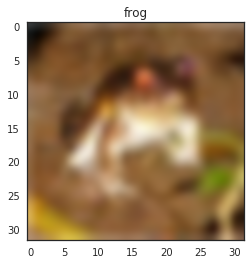

In [5]:
print(np.mean(images[0]), np.std(images[0]))

def show_whitened_image(image, label=None):
    image = unwhiten(image)
    image = image.reshape(32, 32, 3).astype("uint8")
    with sns.axes_style("white"):
        plt.imshow(image, interpolation="bicubic")
    if label:
        plt.title(label_names[label])
    plt.show()

for i in range(1):
    show_whitened_image(images[i], labels[i])

Raw
120.708
4115.23
Whitened
1.49569e-05
1.00126


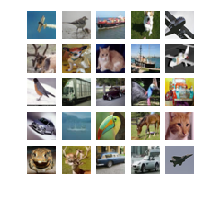

In [6]:
print("Raw")
print(np.mean(all_raw_images))
print(np.var(all_raw_images))

print("Whitened")
print(np.mean(images))
print(np.var(images))

show_images(unwhiten(images))

Whitened Test
0.0128064
0.997227


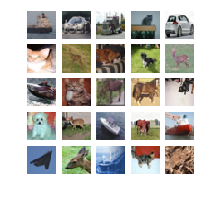

10000


In [7]:
print("Whitened Test")
print(np.mean(test_images))
print(np.var(test_images))

show_images(unwhiten(test_images))
print(len(test_images))

In [8]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

1.1.0
['/gpu:0']


In [9]:
def print_graph_stats(verbose=False):
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        if verbose:
            print('')
            print(shape)
        variable_parametes = 1
        for dim in shape:
            variable_parametes *= dim.value
        if verbose:
            print(variable_parametes)
        total_parameters += variable_parametes

    print("Total params = %s" % total_parameters)


In [15]:
tf.reset_default_graph()

# Get determinism
np.random.seed(1)
random.seed(1)
tf.set_random_seed(1)

# Build our models
input_size = 3*32*32
batch_size = 128 # To use GPU correctly


# VGG based on http://torch.ch/blog/2015/07/30/cifar.html

xavier = tf.contrib.layers.xavier_initializer()
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lr = tf.placeholder(tf.float32, name='lr')

def conv_bn_relu(x, in_channels, out_channels, scope, dropout=True):
    with tf.variable_scope(scope):
        W = tf.get_variable("W", shape=[3, 3, in_channels, out_channels], initializer=xavier)
        b = tf.get_variable("bias", initializer=tf.constant(0.1, shape=[out_channels]))

    conved = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
    # TODO: add spatial batchnorm before relu. Bias can be omitted when using batchnorm
    out = tf.nn.relu(conved + b)
    if dropout:
        out = tf.nn.dropout(out, keep_prob=keep_prob)
    return out

def conv_group(x, in_channels, out_channels, scope):
    with tf.variable_scope(scope):
        conv = conv_bn_relu(x, in_channels, out_channels, "conv_1")
        # TODO: Add variable layer of convs in a group
        conv = conv_bn_relu(conv, out_channels, out_channels, "conv_2", dropout=False)
        pooled = max_pool_2x2(conv) 
    return pooled

def single_h_mlp(x, in_size, out_size, h_size, scope="mlp"):
    with tf.variable_scope(scope):
        W1 = tf.get_variable("W1", shape=[in_size, h_size], initializer=xavier)
        b1 = tf.Variable(tf.constant(0.1, shape=[h_size]))

        W2 = tf.get_variable("W2", shape=[h_size, out_size], initializer=xavier)
        b2 = tf.Variable(tf.constant(0.1, shape=[out_size]))

    x = tf.nn.dropout(x, keep_prob=keep_prob)

    h_layer = tf.matmul(x, W1) + b1
    # TODO: Add batchnorm here
    h_layer = tf.nn.relu(h_layer)
    h_layer = tf.nn.dropout(h_layer, keep_prob=keep_prob)
    
    out = tf.matmul(h_layer, W2) + b2
    return out
        
        
x = tf.placeholder(tf.float32, shape=(None, input_size), name='x')
y_train = tf.placeholder(tf.int32, shape=(batch_size), name='y_train')

x_image = tf.reshape(x, [-1, 32, 32, 3])

# Conv layers
pool_1 = conv_group(x_image, 3, 64, 'group_1') # (16x16x64)
pool_2 = conv_group(pool_1, 64, 128, 'group_2') # (8x8x128)
pool_3 = conv_group(pool_2, 128, 256, 'group_3') # (4x4x256)
pool_4 = conv_group(pool_3, 256, 512, 'group_4') # (2x2x512)
conv_out = conv_group(pool_4, 512, 512, 'group_5') # (1x1x512)

conv_out_flat = tf.reshape(conv_out, [-1, 512])

logits = single_h_mlp(conv_out_flat, 512, 10, 512)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_train, logits=logits)

# loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'bias' not in v.name ]) * 0.0005
loss = tf.reduce_mean(cross_entropy, name="loss")# + loss_l2

# Optimizers
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
global_step = tf.Variable(0, name='global_step', trainable=False)

with tf.control_dependencies(update_ops): # Execute the update_ops for batchnorm before performing the train_step    
#     optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#     lr_decay_rate = (1-1e-7)
#     decayed_lr = tf.train.exponential_decay(lr, global_step, decay_steps=1, decay_rate=lr_decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9)

train_op = optimizer.minimize(loss, global_step=global_step, name='train_op')

#################################
### Finished defining graph
#################################

print_graph_stats(False)
print("Graph ready")


def check_accuracy(test_ims, test_ys, sess):    
    total_correct = 0
    for i in range(len(test_ims) // batch_size):
        logits_out = sess.run(logits, feed_dict={
            x: test_ims[i*batch_size:(i+1)*batch_size],
            keep_prob: 1.0,
        })
        y_pred = np.argmax(logits_out, 1)
        correct = (y_pred - test_ys[i*batch_size:(i+1)*batch_size]) == 0
        total_correct += correct

    acc = np.sum(total_correct) / len(test_ys)

    message = "%s correct out of %s => accuracy: %s" % ( np.sum(total_correct), len(test_ys), acc)
    return acc, message
    
#################################
### Start training
#################################

report = {
    'loss': [],
    'val_acc': [],
}

n_epochs = 75

# annealing_lr = 5e-1

annealing_lr = 2*10e-5 # ADAM LR

annealing_lr = 1e-2

sess = tf.InteractiveSession()
checkpoint_dir = osp.join(osp.expanduser('~/checkpoints'), 'vgg_momentum_%s' % int(time()))
os.makedirs(checkpoint_dir)
checkpoint_location = osp.join(checkpoint_dir, 'model')

# Restore if we're ready
restore_from_checkpoint = None
# restore_from_checkpoint = osp.expanduser('~/checkpoints/vgg_momentum_1497383600/model-780')

# restorer = tf.train.import_meta_graph(restore_from_checkpoint + ".meta")
# restorer.restore(sess, restore_from_checkpoint)

# graph = tf.get_default_graph()
# x = graph.get_tensor_by_name('x:0')
# y_train = graph.get_tensor_by_name('y_train:0')
# keep_prob = graph.get_tensor_by_name('keep_prob:0')
# lr = graph.get_tensor_by_name('lr:0')
# train_op = graph.get_tensor_by_name('train_op:0')
# loss = graph.get_tensor_by_name('loss:0')



def sample(images, labels, n=50):
    sample_indices = random.sample(range(len(images)), n)
    return images[sample_indices], labels[sample_indices]

# Initialize
sess.run(tf.global_variables_initializer()) # This always sets the same values
print("Starting training...\n")
start = datetime.now()
for epoch in range(n_epochs):    
    saver.save(sess, checkpoint_location, global_step=global_step)
    if epoch % 25 == 0:
        annealing_lr /= 2.
        print("Annealed base lr to %s" % annealing_lr)
        
    iters_per_epoch = 50000 // batch_size
    for i in range(iters_per_epoch):
        train_ims, train_labels = sample(images, labels, batch_size)

        _, l = sess.run([train_op, loss], feed_dict={
            x: train_ims,
            y_train: train_labels,
            keep_prob: 0.5,
            lr: annealing_lr
        })

        if i % 50 == 0:
            report['loss'].append(l)
            acc, acc_msg = check_accuracy(*sample(val_images, val_labels, 1000), sess)

            report['val_acc'].append(acc)
            print("loss: %.3f, acc: %.1f%%" % (l, acc*100))
            
    training_time = datetime.now() - start
    saver.save(sess, checkpoint_location, global_step=global_step)

    print("\nepoch: %s   base_lr: %s   loss: %s, elapsed_time: %s" % (epoch, annealing_lr, l, training_time))
    print(acc_msg)
    print()

print("Training time: %s" % training_time)

acc, _ = check_accuracy(test_images, test_labels, sess)
print("Final test accuracy: %.1f%%" % (acc*100))

Total params = 9672778
Graph ready
Starting training...



TypeError: Cannot interpret feed_dict key as Tensor: The name 'save/Const:0' refers to a Tensor which does not exist. The operation, 'save/Const', does not exist in the graph.

In [ ]:
from matplotlib import pyplot as plt
def smooth(vals):
    window = 1
    return np.convolve(vals, np.ones(window)/window, mode='full')

xs = [log / 20 for log in range(len(report['loss']))]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(xs, smooth(report['loss']))
ax1.set_title("Loss")
ax2.plot(xs, smooth(np.log(report['loss'])))
ax2.set_title("Log Loss")
plt.show()

plt.title("Validation accuracy")
ys = smooth(report['val_acc'])
plt.plot(xs, ys)
plt.show()

print("Training time: %s" % training_time)
print("Final validation accuracy: %.1f%%" % (np.mean(report['val_acc'][-10:]) *100))
print("Final test accuracy: %.1f%%" % (acc*100))

In [ ]:

n = 30
offset = 20
fig, axes1 = plt.subplots(n,11, figsize=(16, 3*n/2))
for k in range(10):
    ax = axes1[0][k+1] 
    ax.set_title(label_names[k])

    
render_ims = test_images[int(j) + offset: int(j) + offset + n]

saliency_maps, logits_out = sess.run([h_conv3, logits], feed_dict={
    x: render_ims,
    keep_prob: 1.0,
})

mu, sigma = np.mean(saliency_maps), np.std(saliency_maps)
print(mu, sigma)
for j in range(n):
    im = unwhiten(render_ims[j])

    data = im.reshape(32, 32, 3).astype('uint8')
    axes1[j][0].set_axis_off()
    axes1[j][0].imshow(data, interpolation="bicubic")    
    y_pred = np.argmax(logits_out[j])
        
    for k in range(10):
        ax = axes1[j][k+1] 
        if y_pred == k:
            ax.grid(False)
            for spine in ax.spines.values():
                spine.set_edgecolor('blue')
                spine.set_linewidth(3.0)

            ax.set_yticklabels([])
            ax.set_xticklabels([])                
        else:
            ax.set_axis_off()                
        
        # Clip so that it renders nicely
        rng_min = mu - (0.2 * sigma)
        rng_max = mu + (1.5 * sigma)
        sal_map = np.clip(saliency_maps[j, :, :, k], rng_min, rng_max)      
        ax.imshow(sal_map, cmap="gray", 
                  vmin=rng_min, 
                  vmax=rng_max,
                  interpolation="bicubic",
                 )

plt.show()